Import the required packages.

In [1]:
import cabinetry
cabinetry.set_logging()
import pyhf
import time
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
import seaborn as sns
import numpy as np
import scipy
import pandas as pd
import json

We want to construct a workspace for our hypothesis, i.e. _signal_+_background_. We will start again from a configuration file. As you have already seen by now how the configuration file is structured, we will just load a ready one.  
It can be found in the path `configs/config_excl_AnalysisChallenge.yml`.  
The difference is that now we have also included a signal sample along with its normalization factor.

In [2]:
config = cabinetry.configuration.load('configs/config_excl_AnalysisChallenge.yml')
cabinetry.configuration.print_overview(config)

INFO - cabinetry.configuration - opening config file configs/config_excl_AnalysisChallenge.yml
INFO - cabinetry.configuration - the config contains:
INFO - cabinetry.configuration -   4 Sample(s)
INFO - cabinetry.configuration -   3 Regions(s)
INFO - cabinetry.configuration -   3 NormFactor(s)
INFO - cabinetry.configuration -   1 Systematic(s)


Let's again create the required histograms defined on the configuration file schema. This step in only nessasary because we have added a new `Sample`, the _Signal_.

`cabinetry.templates.build(config)`

Once we have the required histograms saved, we can create a workspace from them.

In [3]:
ws = cabinetry.workspace.build(config)

INFO - cabinetry.workspace - building workspace
WARNING - cabinetry.histo - the modified histogram histograms/SR_tty_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - adding NormFactor mu_tty to sample tty in region SR
DEBUG - cabinetry.workspace - adding OverallSys FlatSys to sample tty in region SR
WARNING - cabinetry.histo - the modified histogram histograms/SR_Wy_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - adding NormFactor mu_Wt to sample Wy in region SR
DEBUG - cabinetry.workspace - adding OverallSys FlatSys to sample Wy in region SR
WARNING - cabinetry.histo - the modified histogram histograms/SR_Signal_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - adding NormFactor mu_Signal to sample Signal in region SR
WARNING - cabinetry.histo - the

Let's print the yields from the workspace.

In [4]:
# get model and observed data
model, data = cabinetry.model_utils.model_and_data(ws)
# obtain pre-fit model predictions
model_pred_prefit = cabinetry.model_utils.prediction(model)
# show yields
cabinetry.tabulate.yields(model_pred_prefit, data, per_bin=False, per_channel=True)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier mu_Signal (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_Wt (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier FlatSys (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-Wy (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_SR (1 new nuisance parameters)
DEBUG - cabinetry.model_utils - total stdev is [[48.447386566150904], [17.61563114031243], [3.2652844864793433]]
DEBUG - cabinetry.model_utils - total stdev per channel is [48.447386566150904, 17.61563114031243, 3.2652844864793433]
INFO - cabinetry.tabulate - yields per channel for pre-fit model prediction:
╒══════════╤════════════════╤════════════════╤══

{'yields_per_channel': [{'sample': 'Signal',
   'CR-Wy': '16.27 ± 0.11',
   'CR-tty': '45.81 ± 0.70',
   'SR': '65.25 ± 1.63'},
  {'sample': 'Wy',
   'CR-Wy': '232.70 ± 46.57',
   'CR-tty': '13.79 ± 2.77',
   'SR': '9.19 ± 1.85'},
  {'sample': 'tty',
   'CR-Wy': '9.39 ± 1.88',
   'CR-tty': '73.69 ± 14.78',
   'SR': '3.86 ± 0.78'},
  {'sample': 'total',
   'CR-Wy': '258.36 ± 48.45',
   'CR-tty': '133.30 ± 17.62',
   'SR': '78.31 ± 3.27'},
  {'sample': 'data', 'CR-Wy': '167.00', 'CR-tty': '74.00', 'SR': '15.00'}]}

Things are looking good thus far! Our workspace contains both the backgrounds and the signal sample. Uncertainties here include both statistical and our background `FlatSys` component.  
However, in order to calculate the _expected_ limit, we will need to perform a background-only fit (in both CRs and SR this time!) and use the result of it as _observations_, instead of real data. To achieve that, we will create a copy of our workspace and then prune the signal sample and its corresponding normalization factor from it. In other words, a _background-only_ workspace.

In [5]:
# prune signal and its normalization factor
BOnly_ws = pyhf.Workspace(ws)._prune_and_rename(prune_samples=['Signal'], prune_modifiers=['mu_Signal'])
# change POI to one of the background normalization factors
dict(BOnly_ws)['measurements'][0]['config']['poi'] = 'mu_tty'

# get model and observed data
BOnly_model, BOnly_data = cabinetry.model_utils.model_and_data(BOnly_ws)

# obtain pre-fit model predictions (b-only)
BOnly_model_pred_prefit = cabinetry.model_utils.prediction(BOnly_model)

# show post-fit yield table
cabinetry.tabulate.yields(BOnly_model_pred_prefit, BOnly_data, per_bin=False, per_channel=True)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier mu_Wt (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier FlatSys (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-Wy (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_SR (1 new nuisance parameters)
DEBUG - cabinetry.model_utils - total stdev is [[48.4378833253431], [17.54221699646245], [2.6306382184870496]]
DEBUG - cabinetry.model_utils - total stdev per channel is [48.4378833253431, 17.54221699646245, 2.6306382184870496]
INFO - cabinetry.tabulate - yields per channel for pre-fit 

{'yields_per_channel': [{'sample': 'Wy',
   'CR-Wy': '232.70 ± 46.56',
   'CR-tty': '13.79 ± 2.77',
   'SR': '9.19 ± 1.85'},
  {'sample': 'tty',
   'CR-Wy': '9.39 ± 1.88',
   'CR-tty': '73.69 ± 14.78',
   'SR': '3.86 ± 0.78'},
  {'sample': 'total',
   'CR-Wy': '242.09 ± 48.44',
   'CR-tty': '87.48 ± 17.54',
   'SR': '13.06 ± 2.63'},
  {'sample': 'data', 'CR-Wy': '167.00', 'CR-tty': '74.00', 'SR': '15.00'}]}

Let's save this background-only workspace in a JSON format, we will use it at the next part of the tutorial in order to re-interpret different signal models.

In [6]:
json.dump(BOnly_ws, open('workspaces/BOnly_ws.json', 'w'))

Now we can perform the background-only fit (in CRs and SR) which will give us the dataset to use as observations.

In [7]:
# get pruned model and pruned observed data
BOnly_model, BOnly_data = cabinetry.model_utils.model_and_data(BOnly_ws)
# fit
fit_results_BOnly_model = cabinetry.fit.fit(BOnly_model, BOnly_data)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier mu_Wt (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier FlatSys (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-Wy (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_SR (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.203                      │              Nfcn = 203              │
│ EDM = 3.95e-06 (Goal: 0.0002

Visualise the model parameter values after the fit (normalisation factors and nuisance parameters).

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


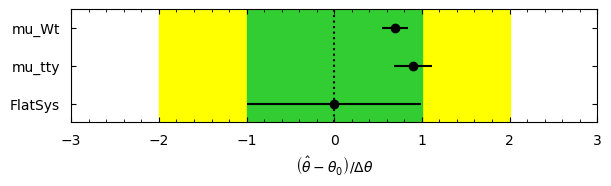

In [8]:
cabinetry.visualize.pulls(fit_results_BOnly_model)

Print the post-fit yields of the above background-only fit.

In [9]:
pruned_BOnly_model_postfit = cabinetry.model_utils.prediction(BOnly_model, fit_results=fit_results_BOnly_model)
cabinetry.tabulate.yields(pruned_BOnly_model_postfit, BOnly_data, per_bin=False, per_channel=True)

DEBUG - cabinetry.model_utils - total stdev is [[12.947080654824601], [8.700535143023428], [0.6674656265000473]]
DEBUG - cabinetry.model_utils - total stdev per channel is [12.947080654824601, 8.700535143023428, 0.6674656265000473]
INFO - cabinetry.tabulate - yields per channel for post-fit model prediction:
╒══════════╤════════════════╤══════════════╤═════════════╕
│ sample   │ CR-Wy          │ CR-tty       │ SR          │
╞══════════╪════════════════╪══════════════╪═════════════╡
│ Wy       │ 161.76 ± 13.13 │ 9.58 ± 0.79  │ 6.41 ± 0.54 │
├──────────┼────────────────┼──────────────┼─────────────┤
│ tty      │ 8.45 ± 1.13    │ 66.30 ± 8.83 │ 3.49 ± 0.47 │
├──────────┼────────────────┼──────────────┼─────────────┤
│ total    │ 170.21 ± 12.95 │ 75.88 ± 8.70 │ 9.90 ± 0.67 │
├──────────┼────────────────┼──────────────┼─────────────┤
│ data     │ 167.00         │ 74.00        │ 15.00       │
╘══════════╧════════════════╧══════════════╧═════════════╛
INFO - cabinetry.tabulate - saving table 

{'yields_per_channel': [{'sample': 'Wy',
   'CR-Wy': '161.76 ± 13.13',
   'CR-tty': '9.58 ± 0.79',
   'SR': '6.41 ± 0.54'},
  {'sample': 'tty',
   'CR-Wy': '8.45 ± 1.13',
   'CR-tty': '66.30 ± 8.83',
   'SR': '3.49 ± 0.47'},
  {'sample': 'total',
   'CR-Wy': '170.21 ± 12.95',
   'CR-tty': '75.88 ± 8.70',
   'SR': '9.90 ± 0.67'},
  {'sample': 'data', 'CR-Wy': '167.00', 'CR-tty': '74.00', 'SR': '15.00'}]}

Build the dataset to be used as _observations_. This is retrieved using the _best-fit_ parameters of the above fit. We will call it _Asimov_.

In [10]:
asimov_parameters = fit_results_BOnly_model.bestfit
asimov_dataset = BOnly_model.expected_data(asimov_parameters)
print("Asimov dataset (Background-only):", asimov_dataset)

Asimov dataset (Background-only): [ 1.70213290e+02  7.58797257e+01  9.89787279e+00 -1.04435828e-03
  9.99895468e-01  9.99607883e-01  1.00302871e+00]


Below we perform the actuall exclusion fit. We get a model and data objects from the initial workspace, which includes the two backgrounds and the signal, and use `pyhf.infer.hypotest` to get the CLs values. For the _expected_ we use our _Asimov_ dataset from above and for the _observed_ we use the actuall data observations.

In [11]:
# calculate (post-fit) CLs
print("* Calculating post-fit CLs *")
time.sleep(1)

# get model and observed data (pre-fit)
model, data = cabinetry.model_utils.model_and_data(ws)
channels = model.config.channels

# calculate expected CLs with respect to POI
try:
    _, CLs_exp_band = pyhf.infer.hypotest(1.0, asimov_dataset, model, return_expected_set=True)
    # keep only ±1 sigma and convert to simple floats
    CLs_exp_band = list(map(lambda x: float(x), CLs_exp_band[1:4]))
except:
    CLs_exp_band = None

# calculate observed CLs with respect to POI
try:
    CLs_obs = pyhf.infer.hypotest(1.0, data, model)
    # convert to simple floats
    CLs_obs = float(CLs_obs)
except:
    CLs_obs = None

# print results
print("Results for POI", model.config.poi_name)
print("CLs_exp_band:", CLs_exp_band)
print("CLs_obs:", CLs_obs)

* Calculating post-fit CLs *


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier mu_Signal (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_Wt (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier FlatSys (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-Wy (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_SR (1 new nuisance parameters)


Results for POI mu_Signal
CLs_exp_band: [1.4187329662334287e-23, 7.508866833635509e-20, 2.769293230285757e-16]
CLs_obs: 4.621518505137136e-16


# From a single model to the whole signal grid
Thus far we have calculated the expected and observed CLs values for a single model point. We can loop the above procedure to calculate those values for all of your signal models. For this we will need a new config file which includes all the signal `Samples` and a corresponding `NormFactor` for each one. The loop fixes all the signal `NormFactors` to zero **but one**, which is set as POI, and the CLs are calculated. Then it proceeds to the next signal `NormFactor`. The results are collected to a dictionary.

In [12]:
config_grid = cabinetry.configuration.load('configs/config_excl_AnalysisChallenge_grid.yml')
cabinetry.configuration.print_overview(config_grid)

INFO - cabinetry.configuration - opening config file configs/config_excl_AnalysisChallenge_grid.yml
INFO - cabinetry.configuration - the config contains:
INFO - cabinetry.configuration -   7 Sample(s)
INFO - cabinetry.configuration -   3 Regions(s)
INFO - cabinetry.configuration -   6 NormFactor(s)
INFO - cabinetry.configuration -   1 Systematic(s)


Build the required histograms.

`cabinetry.templates.build(config_grid)`

and the workspace which now collects all the signals in it.

In [13]:
ws_grid = cabinetry.workspace.build(config_grid)

INFO - cabinetry.workspace - building workspace
WARNING - cabinetry.histo - the modified histogram histograms/SR_tty_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - adding NormFactor mu_tty to sample tty in region SR
DEBUG - cabinetry.workspace - adding OverallSys FlatSys to sample tty in region SR
WARNING - cabinetry.histo - the modified histogram histograms/SR_Wy_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - adding NormFactor mu_Wt to sample Wy in region SR
DEBUG - cabinetry.workspace - adding OverallSys FlatSys to sample Wy in region SR
WARNING - cabinetry.histo - the modified histogram histograms/SR_Signal_1000_300_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - adding NormFactor mu_Signal_1000_300 to sample Signal_1000_300 in region SR
WARN

The for-loop which is running the exclusion fit for each of the signal samples/normalization factors defined in our workspace is constructed below. Initially we get a `model` from our workspace, which includes all the signal samples/normalization factors. Then the `fix_and_calculate` function is used in each iteration of the loop. The function fixes all the `model` parameters except of the one given as argument (`param`) and calculates the CLs values (_observed_ and _expected_) for that particular parameter.

In [14]:
# calculate (post-fit) CLs
print("* Calculating post-fit CLs *")
time.sleep(1)

# get model and observed data (pre-fit)
model, data = cabinetry.model_utils.model_and_data(ws_grid)
channels = model.config.channels

# signal normalisation parameter names
signal_norms = [param for param in model.config.par_names if 'mu_Signal' in param]
# signal normalisation parameter model indices
signal_norms_idx = [model.config.par_map[norm]['slice'].start for norm in signal_norms]

def fix_and_calculate(param):
    '''
    Fix all signal normalisation parameters to zero except the one specified by param
    '''
    
    print(f"Calculating observed and explected CLs for POI {param}")
    # the new poi index, i.e. the parameter to fit
    poi_idx = signal_norms_idx[signal_norms.index(param)]
    # indices of all the signal normalisation parameters except the poi_idx
    fixed_signal_norms_idx = [idx for idx in signal_norms_idx if idx!=poi_idx]

    # set the rest or signal normalisation parameters fixed at zero
    fix_pars = model.config.suggested_fixed().copy()
    init_pars = model.config.suggested_init().copy()
    for idx in fixed_signal_norms_idx:
        fix_pars[idx] = True
        init_pars[idx] = 0.0

    # set POI to param
    poi_index = cabinetry.model_utils._poi_index(model, poi_name=param)
    model.config.set_poi(model.config.par_names[poi_index])

    # calculate expected CLs with respect to POI
    try:
        _, CLs_exp_band = pyhf.infer.hypotest(1.0, asimov_dataset, model, init_pars=init_pars, fixed_params=fix_pars, return_expected_set=True)
        # keep only ±1 sigma and convert to simple floats
        CLs_exp_band = list(map(lambda x: float(x), CLs_exp_band[1:4]))
    except:
        CLs_exp_band = None

    # calculate observed CLs with respect to POI
    try:
        CLs_obs = pyhf.infer.hypotest(1.0, data, model, init_pars=init_pars, fixed_params=fix_pars)
        # convert to simple floats
        CLs_obs = float(CLs_obs)
    except:
        CLs_obs = None

    return [CLs_obs, CLs_exp_band]

# results dictionary
post_fit_significance_results = {}

# create a pool of workers for parallel looping
with ProcessPoolExecutor() as executor:
    print(f"Calculating observed and explected CLs of {len(signal_norms)} models on a pool of {executor._max_workers} workers")
    # loop: pick one signal parameter, fix the rest to zero, calculate CLs
    for i, param in enumerate(signal_norms):
        # submit the job to the pool
        future = executor.submit(fix_and_calculate, param)
        # save the returned future object into the results dictionary
        post_fit_significance_results[param] = future

* Calculating post-fit CLs *


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier mu_Signal_1000_300 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_Signal_1000_500 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_Signal_1500_300 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_Signal_1500_500 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_Wt (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier FlatSys (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-Wy (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_SR (1 new nuisance parameters)


Calculating observed and explected CLs of 4 models on a pool of 8 workers
Calculating observed and explected CLs for POI mu_Signal_1000_300
Calculating observed and explected CLs for POI mu_Signal_1000_500
Calculating observed and explected CLs for POI mu_Signal_1500_300
Calculating observed and explected CLs for POI mu_Signal_1500_500


We will use the helper function `get_results_df` to convert the results dictionary to a `pd.DataFrame` for easier further handling.

In [15]:
# helper function definition
def get_results_df(results: dict):
    '''
    Convert the results dictionary into a dataframe
    '''

    # create dataframe structure
    results_df = pd.DataFrame(columns=['Sq', 
                                       'Hplus',
                                       'observed_p_value',
                                       'expected_p_value',
                                       'expected_p_value_plusOneSigma',
                                       'expected_p_value_minusOneSigma',
                                       'observed_signif',
                                       'expected_signif',
                                       'expected_signif_plusOneSigma',
                                       'expected_signif_minusOneSigma'])

    # fill dataframe from results dictionary
    for i,key in enumerate(results.keys()):
        stop_m = int(key.split('_')[-2])
        chi1_m = int(key.split('_')[-1])
        obs_p_val = float(results[key].result()[0] if results[key].result()[0] is not None else np.nan)
        exp_p_val = float(results[key].result()[1][1] if results[key].result()[1] is not None else np.nan)
        exp_p_val_plusOneSigma = float(results[key].result()[1][2] if results[key].result()[1] is not None else np.nan)
        exp_p_val_minusOneSigma = float(results[key].result()[1][0] if results[key].result()[1] is not None else np.nan)
        obs_signif = scipy.stats.norm.isf(obs_p_val, 0, 1)
        exp_signif = scipy.stats.norm.isf(exp_p_val, 0, 1)
        exp_signif_plusOneSigma = scipy.stats.norm.isf(exp_p_val_plusOneSigma, 0, 1)
        exp_signif_minusOneSigma = scipy.stats.norm.isf(exp_p_val_minusOneSigma, 0, 1)
        
        results_df.loc[i] = pd.Series({'Sq':stop_m,
                                       'Hplus':chi1_m,
                                       'observed_p_value':obs_p_val, 
                                       'expected_p_value':exp_p_val, 
                                       'expected_p_value_plusOneSigma':exp_p_val_plusOneSigma, 
                                       'expected_p_value_minusOneSigma':exp_p_val_minusOneSigma,
                                       'observed_signif':obs_signif, 
                                       'expected_signif':exp_signif, 
                                       'expected_signif_plusOneSigma':exp_signif_plusOneSigma, 
                                       'expected_signif_minusOneSigma':exp_signif_minusOneSigma})

    # calculate DM column
    results_df['DeltaM'] = results_df['Sq'] - results_df['Hplus']
    # fix types
    results_df = results_df.astype({'Sq':int, 'Hplus':int, 'DeltaM':int})
    # bring DeltaM column after chi1
    results_df = results_df[['Sq', 'Hplus', 'DeltaM', 'observed_p_value', 'expected_p_value', 'expected_p_value_plusOneSigma', 'expected_p_value_minusOneSigma', 'observed_signif', 'expected_signif', 'expected_signif_plusOneSigma', 'expected_signif_minusOneSigma']]

    return results_df

In [16]:
# put results in a dataframe
postfit_results_df = get_results_df(post_fit_significance_results)
display(postfit_results_df)

Sq  Hplus  DeltaM  observed_p_value  expected_p_value  \
0  1000    300     700      3.086775e-16      4.625686e-20   
1  1000    500     500      2.693752e-07      4.994624e-10   
2  1500    300    1200      5.428994e-01      1.577974e-01   
3  1500    500    1000      5.493469e-01      1.794045e-01   

   expected_p_value_plusOneSigma  expected_p_value_minusOneSigma  \
0                   1.796495e-16                    8.298406e-24   
1                   1.067496e-07                    1.647159e-12   
2                   4.040909e-01                    4.992820e-02   
3                   4.349622e-01                    6.035215e-02   

   observed_signif  expected_signif  expected_signif_plusOneSigma  \
0         8.085843         9.097407                      8.151547   
1         5.011972         6.109582                      5.187183   
2        -0.107741         1.003552                      0.242772   
3        -0.124011         0.917637                      0.163755   

   expected_signif_minusOneSigma  
0                       9.991549  
1                       6.964560  
2                       1.645550  
3                       1.551824

Unsing information from the above DataFrame we can make a plot to visualise, for instance, the observed limit.

/tmp/ipykernel_26990/3492530198.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivotted = postfit_results_df.pivot('Hplus','Sq','observed_p_value').iloc[::-1]


Text(50.722222222222214, 0.5, '$m(H^{\\pm})$ [GeV]')

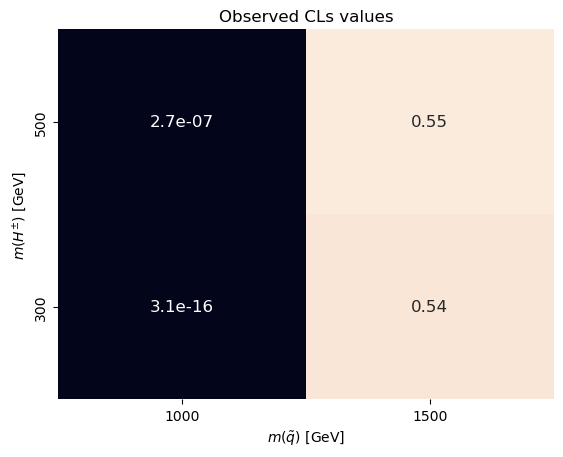

In [17]:
pivotted = postfit_results_df.pivot('Hplus','Sq','observed_p_value').iloc[::-1]
sns.heatmap(pivotted, annot=True, annot_kws={'size': 12}, cbar=False)
plt.title("Observed CLs values")
plt.xlabel(r'$m(\tilde{q})$ [GeV]')
plt.ylabel(r'$m(H^{\pm})$ [GeV]')